# Att bygga ett neuralt nätverk från scratch 

## Neruala nät - introduktion



## Aktiveringsfunktion

## Lossfunktion

Efter en forward pass så kommer den sista outputen i nätet vara en prediktion av någon form. Lossfunktionen används för att beräkna hur fel modelen var i sin prediktion, som sedan används för att uppdatera modelens parametrar. Det finns flera olika lossfunktioner som fungerar bättre för olika typer av modeler och problemtyper. Vanliga lossfunktioner för regression är bland annat Root Mean Squared Error (RMSE), Mean Squared Error (MSE) och Mean Absolute Error (MAE). Det finns många olika typer utav loss funktioner inom klassificering men den vanligaste är Cross Entropy och inom multiklass klassificering då Categorical Cross Entropy(CCE). 

### CCE:
<br>
<div>
<img src="img.jpg" width="300" align = 'left'/>
</div>

yi = målvariabel för klass i, y-hati = predikterad sannolikhet för variabel i. Detta är en summa av loss för alla klasser från en prediktion. 


I vår implementation så använder vi en softmax i vårt sista lager och CCE som loss funktion, eftersom vi har ett klassificeringsproblem. Dessa två är väldigt smidiga att använda tillsammans då derivatan av CCE med avseende på input till softmax, som krävs i bakåtpropagerings steget, blir väldigt simpel att beräkna. Detta är pågrund av vissa matematiska egenskaper som finns hos dessa som vi inte kommer gå in på. 

<div>
<img src="img6.jpg" width="300" align = 'left'/>
</div>

L = CCE(p) s = softmax z = input pi = predikterad sannolikhet för klass i ti = målvärde på sannolikheten för klass i

## Initialisering av nätverket

 Det finns många sätta sätt att initialisera parametervärden för ett neuralt nät. Två saker som är viktigt att ta hänsyn till när man initialiserar sina vikter är; 
 
- Lämplig storlek på sina parametrar, inte för stora och inte för nära 0. Parametrar som är nära 0 kombinerat med tex en sigmoid kan leda till försvinnande gradienter, då gradienten i höga värden på sigmoid är väldigt låg. För höga värden kan istället orsaka exploderande gradienter. Värden mellan [-1,1] är ett vanligt utfallsrum. I våran implementation kommer vi att plocka värden från en uniform distribution mellan [-0.5, 0.5 ].

- Bra varians i sina parametrar. Parametrar plockas oftast ur antingen en uniform distribution eller en vanlig gaussdistribution.

Det finns två vanliga initialiserings metoder för att beräkna distributionen varifrån parametrarna ska dras; He initialization och Zavier initialization. Dessa metoder tar hänsyn till strukturen på de lager parametrarna ska användas till när de beräknar distributionen. Detta visar sig ge bra resultat och går att anpassa beroende på vilken aktiveringsfunktion som används.

## Forward propagation

## Back propagation 

In [111]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
plt.style.use('ggplot')

In [112]:
def train_test_valid_split(data, train_size, valid_size, test_size, random_state = 0):
    np.random.seed(random_state)

    data = np.array(data)
    np.random.shuffle(data)
    n = data.shape[1]
    
    split_one = int(len(data)*train_size)
    split_two = split_one + int(len(data)*valid_size)

    train_data = data[:split_one].T
    y_train = train_data[0]
    X_train = train_data[1:n] / 255.
    
    valid_data = data[split_one:split_two].T
    y_valid = valid_data[0]
    X_valid = valid_data[1:n] / 255.
    
    test_data = data[split_two:].T
    y_test = test_data[0]
    X_test = test_data[1:n] / 255.
        
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [299]:
class Net:
    def __init__(self, random_state):
        self.layers = []
        self.acc_history = None
        self.random_state = random_state
        
    def add_layer(self, n_inputs, n_outputs, activation):
        if activation == 'ReLU':
            activation = self.ReLU
        elif activation == 'sigmoid':
            activation = self.sigmoid
        elif activation == 'softmax':
            activation = self.softmax
        else:
            raise Exception(f"{activation} is not a valid activation function")
                            
        if len(self.layers) > 0:
            if n_inputs == self.layers[-1].n_outputs:
                layer = Layer_Dense(n_inputs, n_outputs, activation, self.random_state)
            else:
                raise Exception('Invalid layer dims')
        else:
            layer = Layer_Dense(n_inputs, n_outputs, activation)
            
        self.layers.append(layer)
                  
    def ReLU(self, Z, derive = False):
        if not derive:
            return np.maximum(Z, 0)
        else:
            return Z > 0
        
    def sigmoid(self, Z, derive = False):
        if not derive:
            return 1/(1 + np.exp(-Z))
        else:
            y = 1/(1 + np.exp(-Z))
            yp = y * (1.0 - y)
            return yp
    
    def softmax(self, Z):
        A = np.exp(Z) / sum(np.exp(Z))
        return A
    
    def one_hot(self, Y, n_classes):
        one_hot_Y = np.zeros((Y.size, n_classes))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y
    
    def update_params(self, layer, dW, db, learning_rate):
        layer.W -= learning_rate * dW
        layer.b -= learning_rate * db
        
    def forward(self, inputs):
        for i, layer in enumerate(self.layers):    
            layer.inputs = inputs
            Z = layer.W.dot(inputs) + layer.b
            A = layer.activation(Z)
            layer.Z = Z
            layer.A = A
            inputs = A
        return A
    
    def backward(self, outputs, Y, learning_rate, n_classes):
        one_hot_y = self.one_hot(Y, n_classes)  
        m = outputs.shape[1]
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                dZ = outputs - one_hot_y
            else:
                dZ = self.layers[i+1].W.T.dot(dZ) * layer.activation(layer.Z, derive = True)
            
            dW = 1/m * dZ.dot(layer.inputs.T)
            db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
            
            self.update_params(layer, dW, db, learning_rate)
    
    def get_predictions(self, prediction):
        return np.argmax(prediction, 0)
    
    def score(self, X, Y):
        predictions = self.get_predictions(self.predict(X))
        return np.sum(predictions == Y) / Y.size
                
    def fit(self, X, Y, X_valid, y_valid, n_classes, epochs, batchsize = None,  learning_rate = 1):
        
        if not batchsize:
            batchsize = X.shape[1]
            
        n_iterations = abs(math.floor(-X.shape[1]/batchsize)) * epochs
        accuracy = np.zeros(n_iterations)        
        
        iteration = 0
        for epoch in range(epochs):
            for start_idx in range(0, X.T.shape[0], batchsize):
                end_idx = min(start_idx + batchsize, X.T.shape[0])
                excerpt = slice(start_idx, end_idx)

                inputs = X.T[excerpt].T
                targets = Y.T[excerpt].T
            
                predictions = self.forward(inputs)
                self.backward(predictions, targets, learning_rate, n_classes)
                a = self.score(X_valid, y_valid)
                accuracy[iteration] = a
                
                if iteration % 25 in [0,25]:
                    print(f'Epoch {epoch+1} Iteration {iteration}/{n_iterations}')
                    print(f'Accuracy: {round(a, 3)}\n-')
                    
                iteration += 1
                
        self.acc_history = accuracy
            
    def predict(self, X): 
        return self.forward(X)

        
class Layer_Dense:
    def __init__(self, n_inputs, n_outputs, activation, random_state = 0):
        np.random.seed(random_state)
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # Parameter initialization. Values are taken from a uniform distribution between 0,1. 
        # Subtract 0.5 to get values between -0.5, 0.5
        
        self.W = np.random.rand(n_outputs, n_inputs) - 0.5
        self.b = np.random.rand(n_outputs, 1) - 0.5
        
        self.activation = activation
        
        self.inputs = None
        self.Z = None
        self.A = None


In [300]:
data = pd.read_csv('../data.csv')

train_size = 0.8
valid_size = 0.1
test_size = 0.1

X_train, y_train, X_test, y_test, X_valid, y_valid = train_test_valid_split(data, 
                                                                            train_size = train_size, 
                                                                            valid_size = valid_size, 
                                                                            test_size = test_size, 
                                                                            random_state = 0)

print(f'Training data - {X_train.shape[1]} samples ({train_size*100}%)\n -')
print(f'Validation data - {X_valid.shape[1]} samples ({valid_size*100}%)\n -')
print(f'Training data - {X_test.shape[1]} samples ({test_size*100}%)')

Training data - 33600 samples (80.0%)
 -
Validation data - 4200 samples (10.0%)
 -
Training data - 4200 samples (10.0%)


In [302]:
net = Net(random_state = 0)

n_classes = 10

net.add_layer(784, 32, 'sigmoid')
net.add_layer(32, 10, 'sigmoid')
net.add_layer(10, n_classes, 'softmax')

learning_rate = 1
epochs = 3
batchsize = 32

net.fit(X_train, y_train, X_valid, y_valid, 
        n_classes = n_classes, 
        batchsize = batchsize, 
        epochs = epochs, 
        learning_rate = learning_rate)


Epoch 1 Iteration 0/3150
Accuracy: 0.121
-
Epoch 1 Iteration 25/3150
Accuracy: 0.122
-
Epoch 1 Iteration 50/3150
Accuracy: 0.363
-
Epoch 1 Iteration 75/3150
Accuracy: 0.588
-
Epoch 1 Iteration 100/3150
Accuracy: 0.596
-
Epoch 1 Iteration 125/3150
Accuracy: 0.711
-
Epoch 1 Iteration 150/3150
Accuracy: 0.763
-
Epoch 1 Iteration 175/3150
Accuracy: 0.778
-
Epoch 1 Iteration 200/3150
Accuracy: 0.813
-
Epoch 1 Iteration 225/3150
Accuracy: 0.801
-
Epoch 1 Iteration 250/3150
Accuracy: 0.832
-
Epoch 1 Iteration 275/3150
Accuracy: 0.829
-
Epoch 1 Iteration 300/3150
Accuracy: 0.843
-
Epoch 1 Iteration 325/3150
Accuracy: 0.846
-
Epoch 1 Iteration 350/3150
Accuracy: 0.863
-
Epoch 1 Iteration 375/3150
Accuracy: 0.862
-
Epoch 1 Iteration 400/3150
Accuracy: 0.82
-
Epoch 1 Iteration 425/3150
Accuracy: 0.879
-
Epoch 1 Iteration 450/3150
Accuracy: 0.872
-
Epoch 1 Iteration 475/3150
Accuracy: 0.882
-
Epoch 1 Iteration 500/3150
Accuracy: 0.876
-
Epoch 1 Iteration 525/3150
Accuracy: 0.88
-
Epoch 1 Iteration

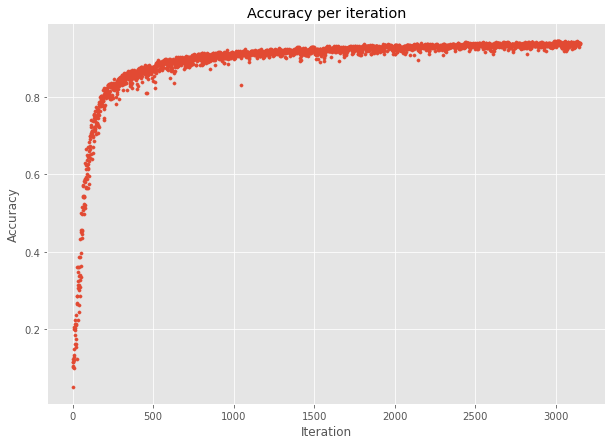

In [303]:
plt.figure(figsize = (10,7))
plt.scatter([i for i in range(len(net.acc_history))], list(net.acc_history), s = 10)
plt.title('Accuracy per iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.show()

In [304]:
print(f'Test set accuracy: {round(net.score(X_test, y_test), 3)*100}%')

Test set accuracy: 93.5%


In [305]:
def get_all_predictions(net, X_test, y_test):
    all_predictions = []
    for i in range(len(X_test)):
        x = X_test[:, i, None]
        prediction = net.predict(x)
        prediction = np.argmax(prediction, 0)[0]
        label = y_test[i]

        all_predictions.append((prediction,label, x))
    return all_predictions

In [198]:
predictions = get_all_predictions(net, X_test, y_test)
wrong_predictions = [(predicted, label, x) for predicted, label, x in predictions if predicted != label]
right_predictions = [(predicted, label, x) for predicted, label, x in predictions if predicted == label]

Prediction:  8
Label:  1


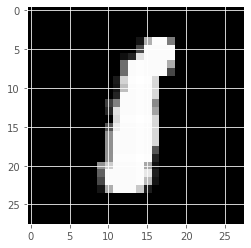

Prediction:  5
Label:  9


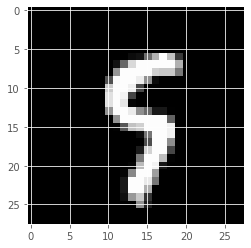

Prediction:  1
Label:  7


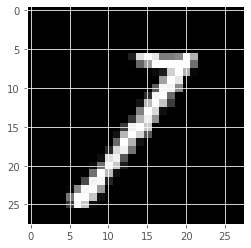

Prediction:  3
Label:  5


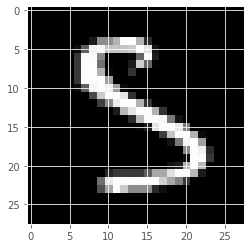

Prediction:  7
Label:  3


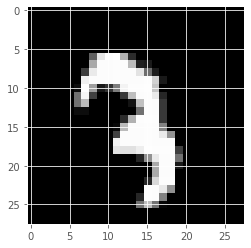

Prediction:  4
Label:  9


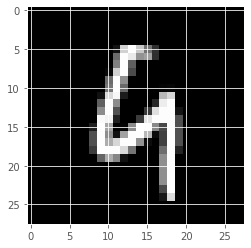

Prediction:  8
Label:  9


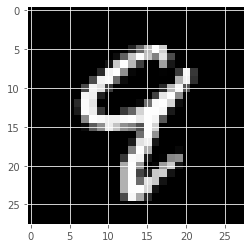

Prediction:  6
Label:  2


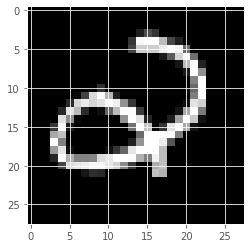

Prediction:  8
Label:  2


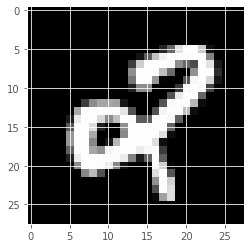

Prediction:  1
Label:  7


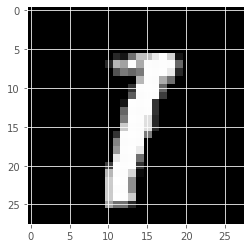

In [199]:
for prediction, label, x in wrong_predictions[:10]:
    print('Prediction: ', prediction)
    print('Label: ', label)
    plt.imshow(x.reshape((28,28)) * 255)
    plt.show()